<a href="https://colab.research.google.com/github/coraldx5/generativeai_intro_book/blob/master/chap08_mnist_digit_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章：オートエンコーダを作ってみよう
- 手書きの数字を入出力するオートエンコーダを作成します

## GPUが使用可能であることを確認（第7章と同じ）
- 手動で設定する場合には「ランタイム」メニュー→「ランタイムのタイプを変更」→「ハードウェア アクセラレータ」をGPU（T4 GPU、など）に設定→「保存」ボタンを押下

In [1]:
!nvidia-smi  # ←GPUが使用可能であることを確認

Thu Aug  8 03:31:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 使用するパッケージのバージョンを指定（第7章と同じ）

In [2]:
# パッケージのアンインストール（削除）
!pip uninstall tensorflow keras tf-keras -y
# パッケージのバージョンを指定してインストール
!pip install tensorflow==2.15.1
!pip install keras==2.15
!pip install tf-keras==2.15

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtyp

## ライブラリのインポート（第7章と同じ）

In [3]:
import tensorflow as tf

# Kerasのインポート
import keras

# ネットワーク（モデル）を構築するための「部品」をインポートします
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Flatten, Dense

# モデルの構造を可視化するためのライブラリをインポートします
from tensorflow.keras.utils import plot_model

# グラフや画像を描画するためのライブラリをインポートします
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
# 結果の再現性を担保するために乱数シードを固定
keras.utils.set_random_seed(821)
tf.config.experimental.enable_op_determinism()

## 学習に使うデータの準備（第7章と同じ）

11490434/11490434 [==============================] - 0s 0us/step
学習用画像の形状:  (60000, 28, 28)
学習用ラベルの形状:  (60000,)
検証用画像の形状:  (10000, 28, 28)
検証用ラベルの形状:  (10000,)


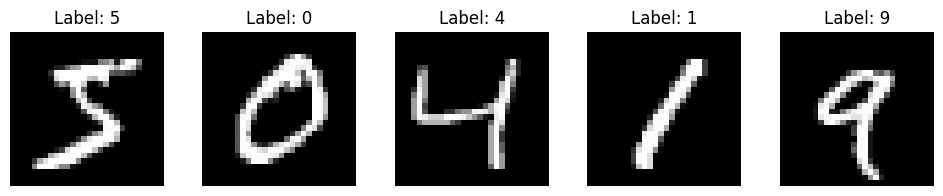

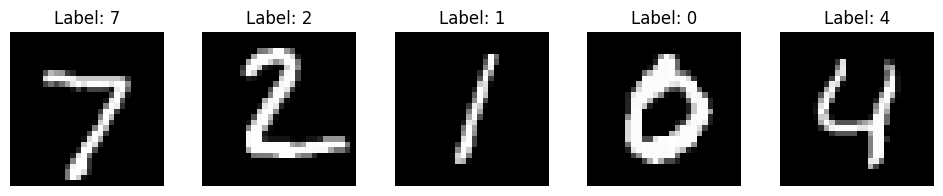

In [4]:
# @title ## データの準備（第7章と同じ）
# MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# データの正規化
x_train = x_train / 255.0
x_test = x_test / 255.0

# データの確認
print("学習用画像の形状: ", x_train.shape)
print("学習用ラベルの形状: ", y_train.shape)
print("検証用画像の形状: ", x_test.shape)
print("検証用ラベルの形状: ", y_test.shape)

# データの可視化
def plot_sample_images(images, labels, num_samples):
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# 学習用データから5個のサンプルを表示
plot_sample_images(x_train, y_train, num_samples=5)
# 検証用データから5個のサンプルを表示
plot_sample_images(x_test, y_test, num_samples=5)

In [5]:
# @title ## 学習用/検証用データに含まれる各ラベルの枚数を確認（第7章と同じ）
# 各ラベルの数を計算する関数
def count_labels(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

# 学習用データと検証用データのラベル数を計算
train_label_counts = count_labels(y_train)
test_label_counts = count_labels(y_test)

# データフレームにまとめる
df = pd.DataFrame({
    'ラベル': list(train_label_counts.keys()),
    '学習用データの数': list(train_label_counts.values()),
    '検証用データの数': [test_label_counts.get(label, 0) for label in train_label_counts.keys()]
})

# データフレームを表示
df

,ラベル,学習用データの数,検証用データの数
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


## オートエンコーダを定義してみよう
- 第7章の"model02"の構造を参考にしたオートエンコーダを作成します

In [6]:
# Decoderを構築するための「部品」をインポートします
from tensorflow.keras.layers import Reshape

# エンコーディングの次元数を設定
encoding_dim = 2

# モデルの定義
autoencoder01 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(128, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),
    Reshape((28, 28))
], name='autoencoder01')

# モデルの構造を表示
autoencoder01.summary()

Model: "autoencoder01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 202258 (790.07 KB)
Trainable params: 20

### モデルを可視化してみよう

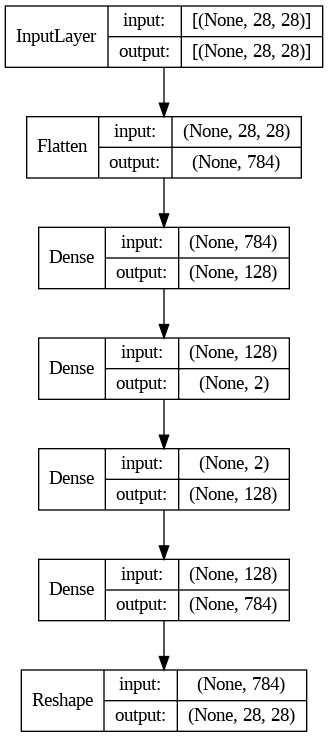

In [7]:
# モデルを可視化して画像を出力
plot_model(autoencoder01, to_file='autoencoder01.png', show_shapes=True, show_layer_names=False)
# 画像を表示
display(Image(filename='autoencoder01.png'))

### モデルのコンパイルと学習

In [8]:
# モデルのコンパイル
autoencoder01.compile(loss='mse',optimizer='adam')

# モデルを１エポックだけ学習
history = autoencoder01.fit(x_train, x_train,
                            epochs=1, # ←１エポックだけ学習させています
                            validation_data=(x_test, x_test))

1875/1875 [==============================] - 17s 6ms/step - loss: 0.0622 - val_loss: 0.0519


### 学習済みモデルを読み込み

In [9]:
from tensorflow.keras.models import load_model
# 指定されたURLから学習済みモデルをダウンロードして保存
!wget -O chap08_autoencoder01-01.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder01-01.h5

# ダウンロードしたファイルを読み込み、autoencoder01に代入
autoencoder01 = load_model('chap08_autoencoder01-01.h5')

--2024-08-08 03:33:46--  https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder01-01.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2470584 (2.4M) [application/octet-stream]
Saving to: ‘chap08_autoencoder01-01.h5’

chap08_autoencoder0 100%[===================>]   2.36M  --.-KB/s    in 0.05s   

2024-08-08 03:33:47 (47.2 MB/s) - ‘chap08_autoencoder01-01.h5’ saved [2470584/2470584]



313/313 [==============================] - 1s 2ms/step


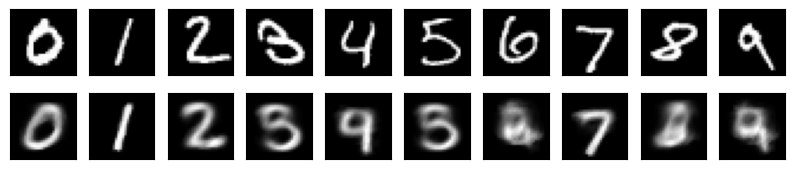

In [10]:
# @title ## オートエンコーダの入出力を確認しよう
# @markdown - このコードセルを実行すると、予め指定した０～９の画像が再構築されて出力されます

# 学習モデルでテスト画像を変換
decoded_imgs01 = autoencoder01.predict(x_test)

# ０～９までの数字のインデックス
digit_index_list = [3,2,1,18,4,15,11,0,61,7]

# 描画する画像サイズの指定
plt.figure(figsize=(10, 2))

# ０～９までの数字の入出力画像を表示
for i,digit_index in enumerate(digit_index_list):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs01[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

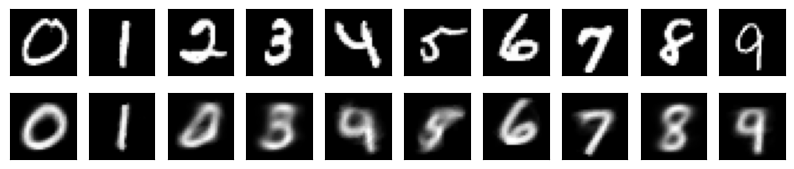

In [11]:
# @title ### 参考：０～９の数字をランダムに選んでデコード具合を確認してみよう
# @markdown - このコードセルを実行するたびに、ランダムに０～９の数字が選択され、デコード具合を確認することができます
import random, time

# 現在時刻からランダムシードを決定する
random_seed = int(time.time())
random.seed(random_seed)

# ０～９までの数字のインデックス
digit_index_list_rnd = []
for lbl in range(10):
    lbl_indices = np.where(y_test == lbl)[0]
    digit_index_list_rnd.append(random.choice(lbl_indices))
#
plt.figure(figsize=(10, 2))
for i,digit_index in enumerate(digit_index_list_rnd):
    # テスト画像を表示
    ax = plt.subplot(2, len(digit_index_list_rnd), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換画像を表示
    ax = plt.subplot(2, len(digit_index_list_rnd), i+1+len(digit_index_list_rnd))
    plt.imshow(decoded_imgs01[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 潜在表現を出力するEncoderの挙動を確認しよう

In [12]:
# エンコーダ部分の定義
encoder01 = keras.models.Model(inputs=autoencoder01.input,
                               outputs=autoencoder01.layers[2].output)

# 検証用データの潜在表現を取得
encoded_imgs01 = encoder01.predict(x_test)

313/313 [==============================] - 0s 1ms/step


1/1 [==============================] - 0s 48ms/step


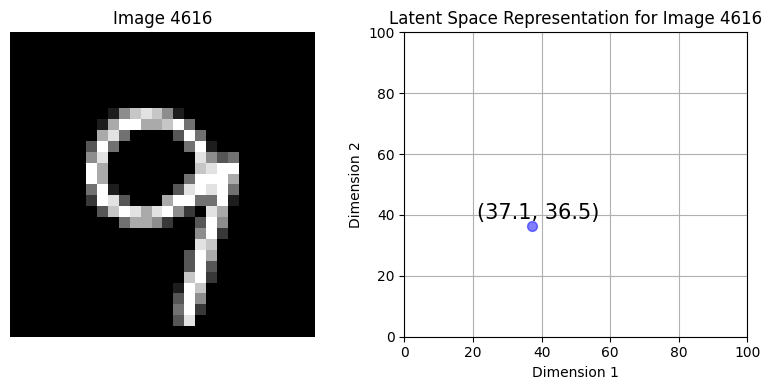

In [13]:
# @title ## 任意の検証用画像を入力して潜在表現を出力しよう
# @markdown - スライドバーを動かして、任意の画像を選択して実行してみましょう

image_index  = 4616 #@param {type:"slider", min:0, max:9999, step:1}
image_to_encode = x_test[image_index]

# 潜在表現を取得
encoded_image = encoder01.predict(np.expand_dims(image_to_encode, axis=0))

# 画像を表示
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_test[image_index], cmap='gray')  # 画像がグレースケールの場合。カラー画像の場合は cmap を省略
plt.title(f'Image {image_index}')
plt.axis('off')

# 潜在表現を表示する場合（例えば2次元の潜在空間の場合）
plt.subplot(1, 2, 2)
if encoded_image.shape[1] == 2:
    plt.scatter(encoded_image[:, 0], encoded_image[:, 1], c='blue', s=50, alpha=0.5)
    plt.title(f'Latent Space Representation for Image {image_index}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xlim(0, 100)  # x軸の範囲を0〜100に設定
    plt.ylim(0, 100)  # y軸の範囲を0〜100に設定
    # 各点の座標を表示
    for (x, y) in zip(encoded_image[:, 0], encoded_image[:, 1]):
        plt.annotate(f'({x:.1f}, {y:.1f})', (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=15, color='black')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Latent representation is not 2D',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=12, color='red')
    plt.title(f'Latent Representation for Image {image_index}')

plt.tight_layout()
plt.show()

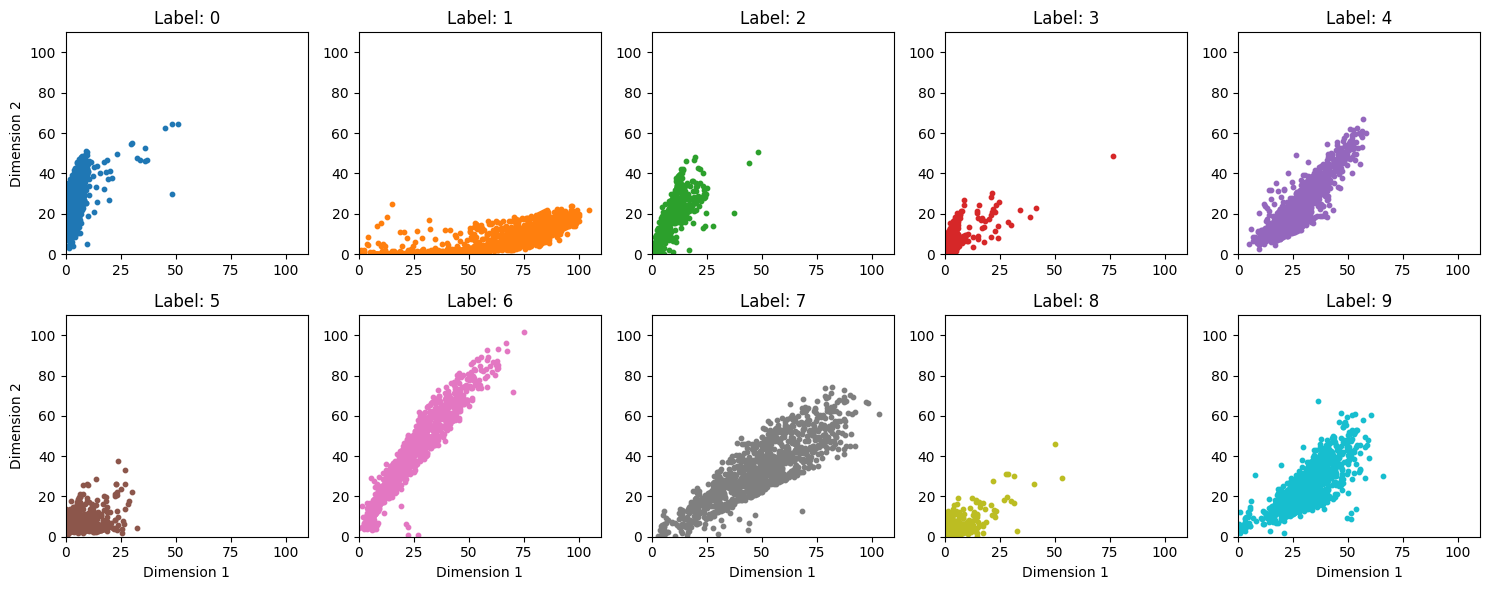

In [14]:
# @title ### 画像の潜在表現を数字別に出力しよう
# @markdown - ０～９の画像の潜在表現を数字ごとに出力します
import matplotlib
# サブプロットを作成
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2行5列のサブプロットを作成
axes = axes.flatten()  # 2次元配列を1次元に変換

for i in range(10):
    # y_test が i であるインデックスを取得
    indices = np.where(y_test == i)

    # encoded_imgs をフィルタリング
    filtered_encoded_imgs = encoded_imgs01[indices]

    # 'tab10' カラーマップから i 番目の色を取得
    color = matplotlib.colormaps['tab10'](i)  # 'tab10' のi番目の色を取得

    # サブプロットの作成
    ax = axes[i]
    ax.scatter(filtered_encoded_imgs[:, 0], filtered_encoded_imgs[:, 1], c=[color], s=10, alpha=1)
    ax.set_xlim(0, 110)
    ax.set_ylim(0, 110)
    ax.set_title(f'Label: {i}')

    # 軸ラベルの設定（省略する場合もあり）
    if i % 5 == 0:
        ax.set_ylabel('Dimension 2')
    if i >= 5:
        ax.set_xlabel('Dimension 1')

# グラフの余白を調整
plt.tight_layout()
plt.show()

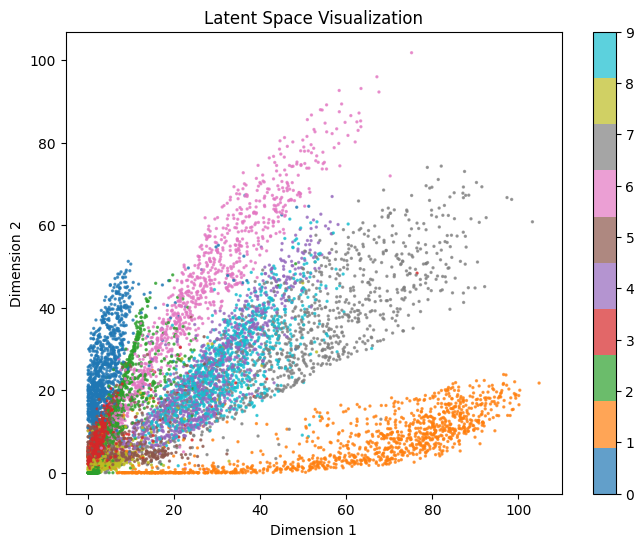

In [15]:
# @title ### すべての検証用画像の潜在表現を出力しよう
# @markdown - 合計10,000枚の検証用画像の潜在表現をプロットします
plt.figure(figsize=(8, 6))
plt.scatter(encoded_imgs01[:, 0], encoded_imgs01[:, 1], c=y_test, s=2, alpha=0.7,cmap='tab10')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

## 潜在表現から画像を生成するDecoderの挙動を確認しよう

1/1 [==============================] - 0s 64ms/step


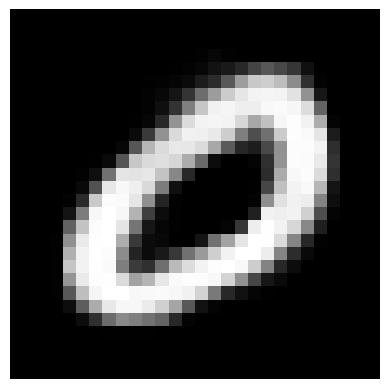

In [16]:
# @title ## 潜在表現から画像を生成しよう
# @markdown - 次元1/2（Dimension1/2）を設定して実行すると、画像が出力されます
Dimension1 = 10 #@param {type:"slider", min:0, max:120, step:1}
Dimension2 = 50 #@param {type:"slider", min:0, max:120, step:1}

from keras.layers import Input
# デコーダ部分の定義
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder01.layers[3]
decoder_layer2 = autoencoder01.layers[4]

decoder01 = Sequential([
    decoder_layer1,
    decoder_layer2
], name='decoder01')

# 2次元ベクトルから画像を生成
def generate_image(latent_vector):
    generated_image = decoder01.predict(np.array([latent_vector]))
    return generated_image.reshape(28, 28)

# サンプルの2次元ベクトル
sample_latent_vector = [Dimension1, Dimension2]

# 画像生成
generated_image = generate_image(sample_latent_vector)

# 生成された画像を表示
# plt.imshow(generated_image, cmap='binary') # 白色背景
plt.imshow(generated_image, cmap='gray') # 黒色背景
plt.axis('off')
# PNG形式で保存
plt.savefig(f'image_{Dimension1}-{Dimension2}.png')
plt.show()

## 潜在表現を複雑化してみよう

In [17]:
# @title ## 学習済みモデルを読み込んで構造を確認しよう
# @markdown - 48次元の潜在空間を持つ`autoencoder02`を読み込みます

# @markdown - 読み込んだ`autoencoder02`モデルの構造を可視化しよう

from tensorflow.keras.models import load_model
# 指定されたURLから学習済みモデルをダウンロードして保存
!wget -O chap08_autoencoder02-01.h5 https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder02-01.h5

# ダウンロードしたファイルを読み込み、autoencoder01に代入
autoencoder02 = load_model('chap08_autoencoder02-01.h5')

# モデルの構造を表示
autoencoder02.summary()

--2024-08-08 03:33:53--  https://raw.githubusercontent.com/coraldx5/generativeai_intro_book/master/chap08_autoencoder02-01.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2612160 (2.5M) [application/octet-stream]
Saving to: ‘chap08_autoencoder02-01.h5’

chap08_autoencoder0 100%[===================>]   2.49M  --.-KB/s    in 0.05s   

2024-08-08 03:33:54 (47.9 MB/s) - ‘chap08_autoencoder02-01.h5’ saved [2612160/2612160]

Model: "autoencoder02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               

313/313 [==============================] - 1s 2ms/step


<Figure size 1000x300 with 0 Axes>

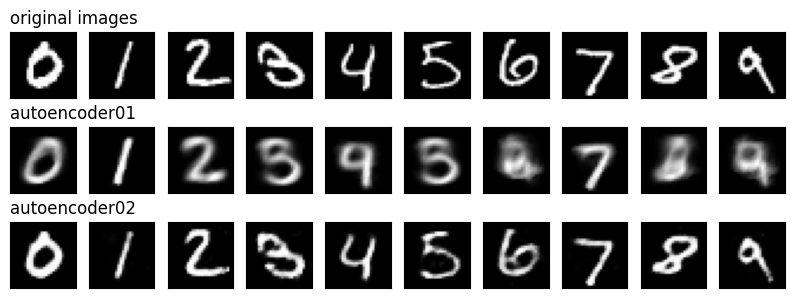

In [18]:
# @title ## オートエンコーダの入出力を確認しよう
# @markdown - このコードセルを実行すると、予め指定した０～９の画像が再構築されて出力されます

# 学習モデルでテスト画像を変換
decoded_imgs02 = autoencoder02.predict(x_test)

# ０～９までの数字のインデックスを定義
digit_index_list = [3,2,1,18,4,15,11,0,61,7]

# 描画する画像サイズの指定
plt.figure(figsize=(10, 3))

# 各行のラベルを設定
labels = ["original images", "autoencoder01", "autoencoder02"]

# 図全体のレイアウトを調整
plt.figure(figsize=(10, 3.5))
# plt.subplots_adjust(hspace=0.1)  # 行間の隙間を広くする

# 各行にラベルを付ける
for row, label in enumerate(labels):
    ax = plt.subplot(3, len(digit_index_list), row * len(digit_index_list) + 1)
    ax.set_title(label, loc='left')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i, digit_index in enumerate(digit_index_list):
    # 入力画像を表示
    ax = plt.subplot(3, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder01による変換画像を表示
    ax = plt.subplot(3, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs01[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder02による変換画像を表示
    ax = plt.subplot(3, len(digit_index_list), i+1+2*len(digit_index_list))
    plt.imshow(decoded_imgs02[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 参考：自分でオートエンコーダを定義して学習してみよう

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0217 - val_loss: 0.0102
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.004

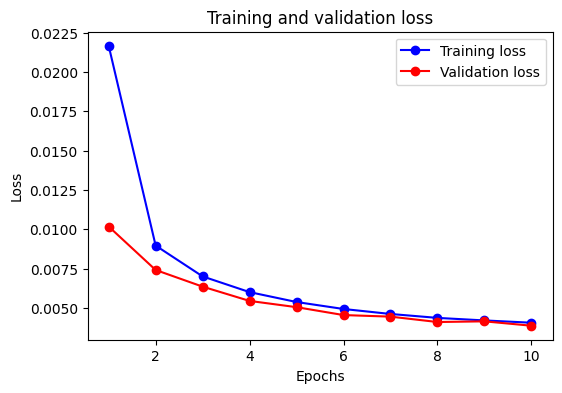

313/313 [==============================] - 1s 2ms/step


In [19]:
# @title モデルの定義と学習
# @markdown - スライダーを動かして、潜在空間の次元数を設定します
# エンコーディングの次元数を設定
encoding_dim  = 80 #@param {type:"slider", min:0, max:128, step:1}

# エポック数の設定
# @markdown - スライダーを動かして、学習回数（エポック数）を設定します
epoch_number  = 10 #@param {type:"slider", min:1, max:50, step:1}

# 学習曲線を描画する関数
def plot_learning_curve(history):
    # 学習用データと検証用データの損失を取得
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # エポック数の範囲を設定
    epochs = range(1, len(loss) + 1)

    # 損失をプロット
    plt.figure(figsize=(6, 4))  # グラフのサイズを設定
    plt.plot(epochs, loss, 'bo-', label='Training loss')  # 学習用データの損失をプロット
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')  # 検証用データ損失をプロット
    plt.title('Training and validation loss')  # グラフのタイトル
    plt.xlabel('Epochs')  # X軸のラベル
    plt.ylabel('Loss')  # Y軸のラベル
    plt.legend()  # 凡例を表示

    plt.show()  # グラフを表示

# モデル構築
my_autoencoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(encoding_dim, activation='relu'),
    Dense(128, activation='relu'),
    Dense(28 * 28, activation='sigmoid'),  # 出力ユニットを 28 * 28 に設定
    Reshape((28, 28))  # 出力を 28x28x1 の形に戻す
], name='my_autoencoder')

# モデルのコンパイル
my_autoencoder.compile(loss='mse',optimizer='adam')

# モデルの学習
history = my_autoencoder.fit(x_train, x_train,
                             epochs=epoch_number,
                             validation_data=(x_test, x_test))
plot_learning_curve(history)

# 学習モデルでテスト画像を変換
my_decoded_imgs = my_autoencoder.predict(x_test)

<Figure size 1000x300 with 0 Axes>

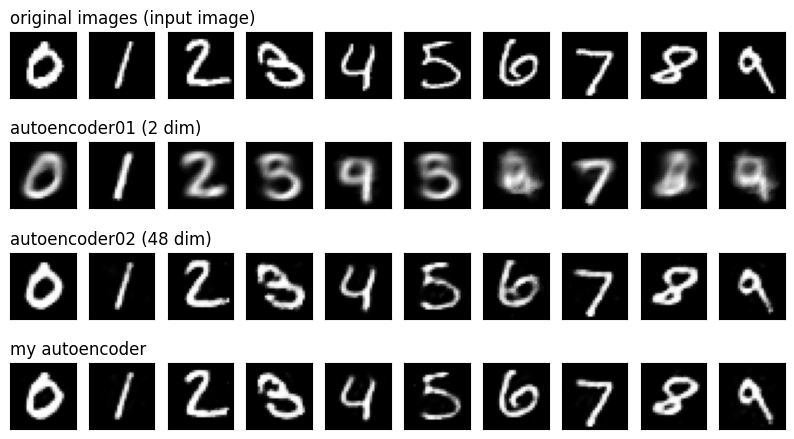

In [20]:
# @title ## オートエンコーダの入出力を確認しよう
# @markdown - このコードセルを実行すると、予め指定した０～９の画像が再構築されて出力されます

# ０～９までの数字のインデックス
digit_index_list = [3,2,1,18,4,15,11,0,61,7]

# 描画する画像サイズの指定
plt.figure(figsize=(10, 3))

# 各行のラベルを設定
labels = ["original images (input image)", "autoencoder01 (2 dim)", "autoencoder02 (48 dim)", "my autoencoder"]

# 図全体のレイアウトを調整
plt.figure(figsize=(10, 5.5))
# plt.subplots_adjust(hspace=0.1)  # 行間の隙間を広くする

# 各行にラベルを付ける
for row, label in enumerate(labels):
    ax = plt.subplot(4, len(digit_index_list), row * len(digit_index_list) + 1)
    ax.set_title(label, loc='left')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

for i, digit_index in enumerate(digit_index_list):
    # 入力画像を表示
    ax = plt.subplot(4, len(digit_index_list), i+1)
    plt.imshow(x_test[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder01による変換画像を表示
    ax = plt.subplot(4, len(digit_index_list), i+1+len(digit_index_list))
    plt.imshow(decoded_imgs01[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # autoencoder02による変換画像を表示
    ax = plt.subplot(4, len(digit_index_list), i+1+2*len(digit_index_list))
    plt.imshow(decoded_imgs02[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # my_autoencoderによる変換画像を表示
    ax = plt.subplot(4, len(digit_index_list), i+1+3*len(digit_index_list))
    plt.imshow(my_decoded_imgs[digit_index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()